In [1]:
# Needed for DeepSort

!pip install deep_sort_realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 20.5 MB/s eta 0:00:00


In [2]:
# Cloning the YOLOv7 repo and setting up dependencies

!git clone https://github.com/WongKinYiu/yolov7

# Download pre-trained weights

%cd yolov7
!wget https://raw.githubusercontent.com/lihaoranIcefire/VideoHeadCount/main/bridge_photo.jpg
!wget https://raw.githubusercontent.com/lihaoranIcefire/VideoHeadCount/main/bridge_cut.mp4
!wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7.pt
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7x.pt
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6.pt
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6.pt
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-d6.pt
# !wget https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-e6e.pt

Cloning into 'yolov7'...
remote: Enumerating objects: 1197, done.
remote: Total 1197 (delta 0), reused 0 (delta 0), pack-reused 1197 (from 1)
Receiving objects: 100% (1197/1197), 74.23 MiB | 24.28 MiB/s, done.
Resolving deltas: 100% (519/519), done.
/content/yolov7
--2024-09-17 09:17:26--  https://raw.githubusercontent.com/lihaoranIcefire/VideoHeadCount/main/bridge_photo.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 321091 (314K) [image/jpeg]
Saving to: ‘bridge_photo.jpg’

bridge_photo.jpg    100%[===================>] 313.57K  --.-KB/s    in 0.02s   

2024-09-17 09:17:26 (18.6 MB/s) - ‘bridge_photo.jpg’ saved [321091/321091]

--2024-09-17 09:17:26--  https://raw.githubusercontent.com/lihaoranIcefire/VideoHeadCount/main/bridge_cut.mp4
Resolving raw.git

In [43]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import time
import cv2
from deep_sort_realtime.deepsort_tracker import DeepSort
import torch
import os
import sys
from pathlib import Path

In [4]:
# Needed for definition of HeadCounter.process

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import check_img_size, check_requirements, check_imshow, non_max_suppression, apply_classifier, \
    scale_coords, xyxy2xywh, strip_optimizer, set_logging, increment_path
from utils.plots import plot_one_box
from utils.torch_utils import select_device, load_classifier, time_synchronized, TracedModel

In [22]:
class HeadCounter:
    '''
    Counter the number of heads in an image or a video.
    '''

    def __init__(self,
                 weights=["yolov7.pt"],
                 img_size=640,
                 conf_thres=0.25,
                 iou_thres=0.45,
                 device='cpu',
                 view_img=False,
                 save_txt=False,
                 save_conf=False,
                 nosave=False,
                 classes=None,
                 agnostic_nms=False,
                 augment=False,
                 update=False,
                 project='runs/detect',
                 name='exp',
                 exist_ok=False,
                 no_trace=False,
                 max_age=5):
        self.opt = {
            'weights': weights,
            'img-size': img_size,
            'conf-thres': conf_thres,
            'iou-thres': iou_thres,
            'device': device,
            'view-img': view_img,
            'save-txt': save_txt,
            'save-conf': save_conf,
            'nosave': nosave,
            'classes': classes,
            'agnostic-nms': agnostic_nms,
            'augment': augment,
            'update': update,
            'project': project,
            'name': name,
            'exist-ok': exist_ok,
            'no-trace': no_trace
        }
        self.tracker = DeepSort(max_age=max_age)

    def process(self, source="inference/images", save_img=False):

        '''
        Build a yolo7 model that generates bounding boxes with confidence scores of objects.
        Return a list of bounding boxes with confidence scores and labels, a list of frames decorated by bounding boxes is returned,
        and a decorated video is exported to `runs/detect`.
        '''

        ################################# This code snippet is taken from https://github.com/WongKinYiu/yolov7/blob/main/detect.py

        self.boxes = []
        self.frames = []


        weights, view_img, save_txt, imgsz, trace = self.opt['weights'], self.opt['view-img'], self.opt['save-txt'], self.opt['img-size'], not self.opt['no-trace']

        save_img = not self.opt['nosave'] and not source.endswith('.txt')  # save inference images
        webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(
            ('rtsp://', 'rtmp://', 'http://', 'https://'))

        # Directories
        save_dir = Path(increment_path(Path(self.opt['project']) / self.opt['name'], exist_ok=self.opt['exist-ok']))  # increment run
        (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

        # Initialize
        set_logging()
        device = select_device(self.opt['device'])
        half = (device.type != 'cpu')  # half precision only supported on CUDA

        # Load model
        model = attempt_load(weights, map_location=device)  # load FP32 model
        stride = int(model.stride.max())  # model stride
        imgsz = check_img_size(imgsz, s=stride)  # check img_size

        if trace:
            model = TracedModel(model, device, self.opt['img-size'])

        if half:
            model.half()  # to FP16

        # Second-stage classifier
        classify = False
        if classify:
            modelc = load_classifier(name='resnet101', n=2)  # initialize
            modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model']).to(device).eval()

        # Set Dataloader
        vid_path, vid_writer = None, None
        if webcam:
            view_img = check_imshow()
            torch.backends.cudnn.benchmark = True  # set True to speed up constant image size inference
            dataset = LoadStreams(source, img_size=imgsz, stride=stride)
        else:
            dataset = LoadImages(source, img_size=imgsz, stride=stride)

        # Get names and colors
        names = model.module.names if hasattr(model, 'module') else model.names
        colors = [[np.random.randint(0, 255) for _ in range(3)] for _ in names]

        # Run inference
        if device.type != 'cpu':
            model(torch.zeros(1, 3, imgsz, imgsz).to(device).type_as(next(model.parameters())))  # run once
        old_img_w = old_img_h = imgsz
        old_img_b = 1

        t0 = time.time()
        for path, img, im0s, vid_cap in dataset:
            img = torch.from_numpy(img).to(device)
            img = img.half() if half else img.float()  # uint8 to fp16/32
            img /= 255.0  # 0 - 255 to 0.0 - 1.0
            if img.ndimension() == 3:
                img = img.unsqueeze(0)

            # Warmup
            if device.type != 'cpu' and (old_img_b != img.shape[0] or old_img_h != img.shape[2] or old_img_w != img.shape[3]):
                old_img_b = img.shape[0]
                old_img_h = img.shape[2]
                old_img_w = img.shape[3]
                for i in range(3):
                    model(img, augment=self.opt['augment'])[0]

            # Inference
            t1 = time_synchronized()
            with torch.no_grad():   # Calculating gradients would cause a GPU memory leak
                pred = model(img, augment=self.opt['augment'])[0]
            t2 = time_synchronized()

            # Apply NMS
            pred = non_max_suppression(pred, self.opt['conf-thres'], self.opt['iou-thres'], classes=self.opt['classes'], agnostic=self.opt['agnostic-nms'])
            t3 = time_synchronized()

            # Apply Classifier
            if classify:
                pred = apply_classifier(pred, modelc, img, im0s)

            self.boxes.extend(pred)
            self.frames.append(im0s)

            # Process detections
            for i, det in enumerate(pred):  # detections per image
                if webcam:  # batch_size >= 1
                    p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
                else:
                    p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

                p = Path(p)  # to Path
                save_path = str(save_dir / p.name)  # img.jpg
                txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # img.txt
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
                if len(det):
                    # Rescale boxes from img_size to im0 size
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                    # Print results
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class
                        s += f"{n} {names[int(c)]}{'s' * (n > 1)}, "  # add to string

                    # Write results
                    for *xyxy, conf, cls in reversed(det):
                        if save_txt:  # Write to file
                            xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                            line = (cls, *xywh, conf) if self.opt['save-conf'] else (cls, *xywh)  # label format
                            with open(txt_path + '.txt', 'a') as f:
                                f.write(('%g ' * len(line)).rstrip() % line + '\n')

                        if save_img or view_img:  # Add bbox to image
                            label = f'{names[int(cls)]} {conf:.2f}'
                            plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=1)

                # Print time (inference + NMS)
                print(f'{s}Done. ({(1E3 * (t2 - t1)):.1f}ms) Inference, ({(1E3 * (t3 - t2)):.1f}ms) NMS')

                # Stream results
                if view_img:
                    cv2.imshow(str(p), im0)
                    cv2.waitKey(1)  # 1 millisecond

                # Save results (image with detections)
                if save_img:
                    if dataset.mode == 'image':
                        cv2.imwrite(save_path, im0)
                        print(f" The image with the result is saved in: {save_path}")
                    else:  # 'video' or 'stream'
                        if vid_path != save_path:  # new video
                            vid_path = save_path
                            if isinstance(vid_writer, cv2.VideoWriter):
                                vid_writer.release()  # release previous video writer
                            if vid_cap:  # video
                                fps = vid_cap.get(cv2.CAP_PROP_FPS)
                                w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                                h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                            else:  # stream
                                fps, w, h = 30, im0.shape[1], im0.shape[0]
                                save_path += '.mp4'
                            vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                        vid_writer.write(im0)

        if save_txt or save_img:
            s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
            #print(f"Results saved to {save_dir}{s}")

        print(f'Done. ({time.time() - t0:.3f}s)')

        return self.boxes, self.frames

    def count_heads(self, original_frames):
        '''
        Gradually updating a tracker that only keeps track of people in real time,
        and finally return the total number of people ever showed up in the video.
        '''
        cnt = 0
        for box, frame in zip(self.boxes, original_frames):
            bbs = [(b[:4].tolist(),float(b[4]),int(b[5])) for b in box if int(b[5])==0] # b[5] == 0 represent people
            tracks = self.tracker.update_tracks(bbs, frame=frame)
            cnt = max(cnt, max(int(track.track_id) for track in tracks))
        return cnt

In [23]:
# Initialize a HeadCounter model

model = HeadCounter(conf_thres=0)

/usr/local/lib/python3.10/dist-packages/deep_sort_realtime/embedder/embedder_pytorch.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.lo

In [24]:
# Process the target video, return the bounding boxes and decorated frames

# boxes, frames = model.process(source="shot.jpg")
boxes, frames = model.process(source="bridge_cut.mp4")

/content/yolov7/models/experimental.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(w, map_location=map_location)  # load


Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
 Convert model to Traced-model... 


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:811: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at aten/src/ATen/core/TensorBody.h:489.)
  param_grad = param.grad


 traced_script_module saved! 
 model is traced! 

video 1/1 (1/11) /content/yolov7/bridge_cut.mp4: 209 persons, 1 bicycle, 30 cars, 12 motorcycles, 8 airplanes, 11 trucks, 5 boats, 1 stop sign, 2 birds, 3 horses, 1 sheep, 4 cows, 9 umbrellas, 1 frisbee, 1 kite, 2 clocks, Done. (1530.5ms) Inference, (314.6ms) NMS
video 1/1 (2/11) /content/yolov7/bridge_cut.mp4: 209 persons, 1 bicycle, 29 cars, 12 motorcycles, 9 airplanes, 10 trucks, 5 boats, 1 stop sign, 2 birds, 3 horses, 1 sheep, 5 cows, 9 umbrellas, 1 frisbee, 1 kite, 2 clocks, Done. (1348.1ms) Inference, (325.4ms) NMS
video 1/1 (3/11) /content/yolov7/bridge_cut.mp4: 210 persons, 1 bicycle, 28 cars, 12 motorcycles, 10 airplanes, 9 trucks, 5 boats, 1 stop sign, 2 birds, 5 horses, 4 cows, 9 umbrellas, 1 frisbee, 1 tv, 2 clocks, Done. (1346.5ms) Inference, (313.6ms) NMS
video 1/1 (4/11) /content/yolov7/bridge_cut.mp4: 200 persons, 1 bicycle, 18 cars, 14 motorcycles, 10 airplanes, 7 trucks, 6 boats, 1 traffic light, 1 stop sign, 2 horses

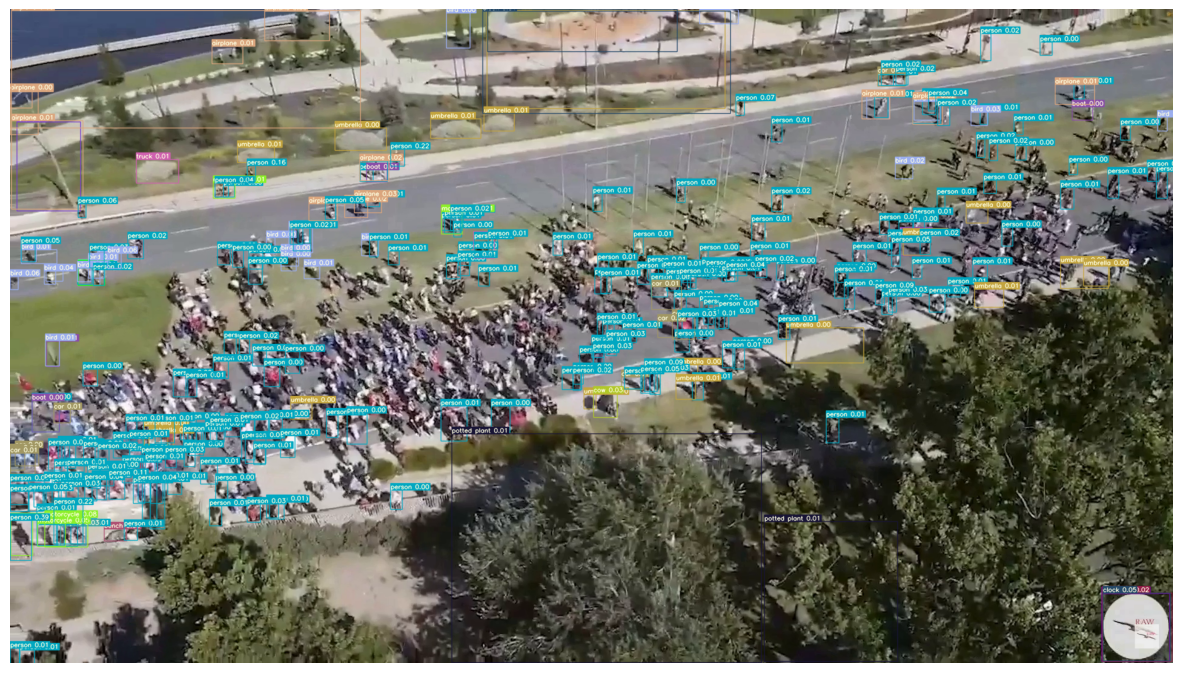

In [62]:
# Print a few decorated frames

plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(frames[5], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

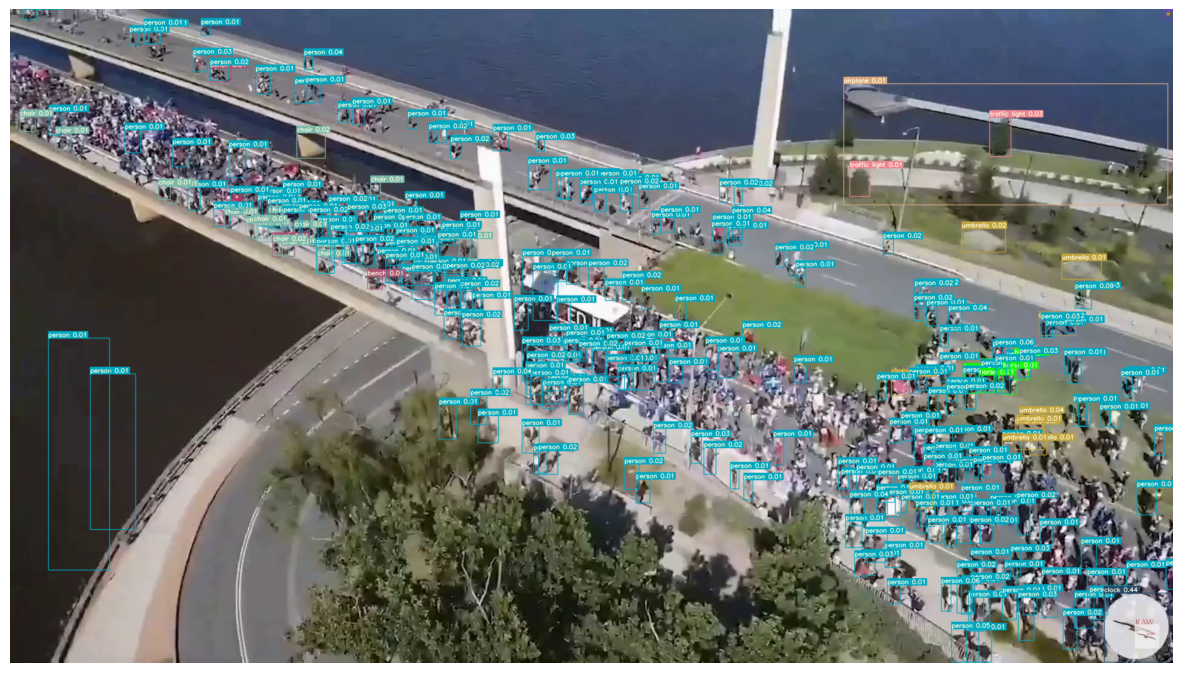

In [63]:
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(frames[6], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [51]:
# Get the original frames of the video
# 'bridge_cut.mp4' is cut of the first few and last few frames of the video 'bridge.mp4'

cap = cv2.VideoCapture('bridge_cut.mp4')
original_frames = []
ret, frame = cap.read()
while ret:
    original_frames.append(frame)
    ret, frame = cap.read()

In [ ]:
plt.figure(figsize=(25,20))
plt.imshow(cv2.cvtColor(original_frames[-1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [25]:
# Counter the total number of people showed up in the video

model.count_heads(original_frames)

456